In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima

import os

In [2]:
def create_date_range(start='2018-08-31', end='2024-08-31', freq='M', periods=None):
    try:
        date_range = pd.date_range(
            start=start, 
            end=end, 
            freq=freq, 
            periods=periods
        )
        return date_range
    except Exception as e:
        print(f"Error creating date range: {e}")
        return None

In [3]:
cwd = os.getcwd()
cwd = '/'.join(cwd.split('/')[:-1])

df = pd.read_pickle(f'{cwd}/Datasets/home_value_index_co.pkl')
df

,RegionName,home_value_index
0,Denver,"[185504.77713814235, 186436.9467333193, 187388..."
1,Colorado Springs,"[160233.8979212204, 160434.15882747434, 160613..."
2,Fort Collins,"[190025.1940645129, 189747.6199006619, 190250...."
3,Boulder,"[223728.4609382274, 224677.8012129301, 225848...."
4,Greeley,"[172977.51375893544, 173245.11588292255, 17279..."
5,Pueblo,"[106730.7157606941, 106808.09563774924, 106955..."
6,Grand Junction,"[139594.79435051687, 139592.72784898907, 13836..."
7,Glenwood Springs,"[195265.96574503157, 195867.57759199225, 19659..."
8,Edwards,"[324732.96331823803, 325443.64580434107, 32660..."
9,Durango,"[262372.9925618727, 262931.2033945226, 263801...."


In [4]:
region = 'Boulder'
attribute = 'home_value_index'

values = df[df['RegionName'] == region] #Select region
values = values[attribute] #Select column
values = values.to_numpy()[0] #Convert to numpy array#Create date range
date_range = create_date_range(start='2000-01-31', end='2024-09-30', freq='M')

data = pd.DataFrame({'date': date_range, 'value': values})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index(data['date']).drop('date', axis=1)
data = data.resample("MS").last()
data.head()

/var/folders/y_/b1tvl6l53p3_kgr4vjlhss9w0000gn/T/ipykernel_3092/3448905241.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


,value
date,
2000-01-01,223728.460938
2000-02-01,224677.801213
2000-03-01,225848.352857
2000-04-01,228292.987531
2000-05-01,230947.552744


Data is non-stationary, performing differencing.
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2620.309, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2006.217, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2501.387, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2294.662, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1936.968, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2716.028, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2719.644, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2722.505, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2719.124, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2711.121, Time=0.07 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 1.825 seconds
Optimal ARIMA order: (3, 1, 0)
RMSE: 12028.160292327739
MAE: 11513.950236590546
MAPE: 1.58%


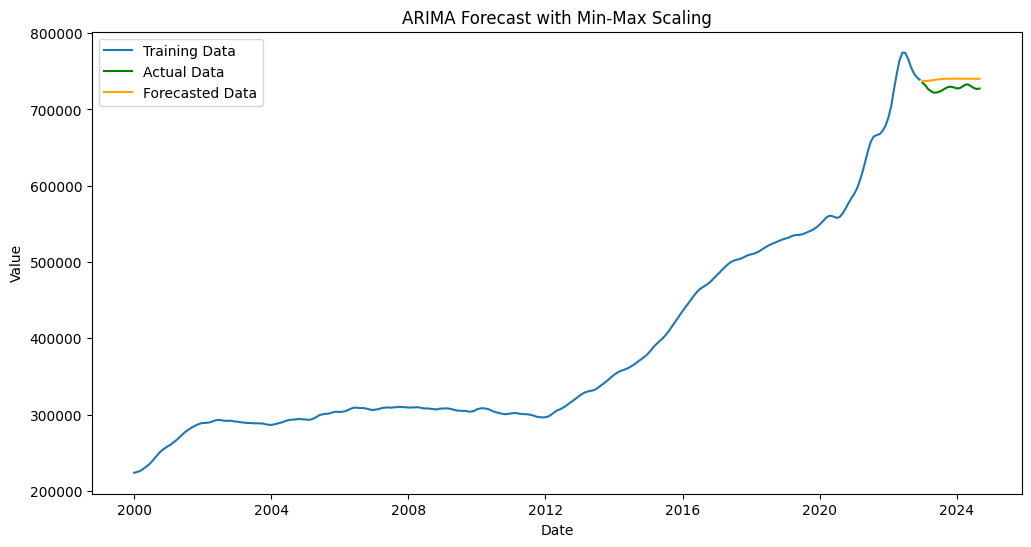

In [6]:
# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Scale the data
scaled_values = scaler.fit_transform(data[['value']])  # Ensure it's 2D for MinMaxScaler
data['scaled_value'] = scaled_values

# Use scaled data for training and testing
train = data[data.index.year < 2023]['scaled_value']
test = data[data.index.year >= 2023]['scaled_value']

# Check for stationarity and differencing if needed
result = adfuller(train)
if result[1] > 0.05:
    print("Data is non-stationary, performing differencing.")
    d = 1
else:
    print("Data is stationary.")
    d = 0

# Use auto_arima for optimal p, d, q parameters
stepwise_model = auto_arima(train, 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3, d=d,
                            seasonal=False, trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)

# Display the chosen order
print(f"Optimal ARIMA order: {stepwise_model.order}")

# Fit ARIMA model
model = ARIMA(train, order=stepwise_model.order)
fitted_model = model.fit()

# Forecast
forecast_steps = len(test)  # Predict for the test set length
forecast = fitted_model.forecast(steps=forecast_steps)

# Reverse scaling of forecast and test data
forecast_original = scaler.inverse_transform(forecast.values.reshape(-1, 1)).flatten()
test_original = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()

# Evaluation metrics on original scale
rmse = np.sqrt(mean_squared_error(test_original, forecast_original))
mae = mean_absolute_error(test_original, forecast_original)

# MAPE calculation
mape = np.mean(np.abs((test_original - forecast_original) / test_original)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data[data.index.year < 2023].index, scaler.inverse_transform(train.values.reshape(-1, 1)), label="Training Data")
plt.plot(data[data.index.year >= 2023].index, test_original, label="Actual Data", color='green')
plt.plot(data[data.index.year >= 2023].index, forecast_original, label="Forecasted Data", color='orange')
plt.title("ARIMA Forecast with Min-Max Scaling")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()
